In [3]:
# 1. Combine Nutri + NOVA predictions into one dataframe

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

RESULTS_DIR = "../results"
plot_dir = os.path.join(RESULTS_DIR, "interpretability_combined")
os.makedirs(plot_dir, exist_ok=True)

# Load both test files
test_nutri = pd.read_csv(os.path.join(RESULTS_DIR, "data_def_test_with_lgb_nutri_preds.csv"), sep=";")
test_nova  = pd.read_csv(os.path.join(RESULTS_DIR, "data_def_test_with_lgb_nova_preds.csv"),  sep=";")

df = test_nutri.copy()
df["nutri_true"] = df["nutriscore"]
df["nova_true"]  = test_nova["nova_group"]

df["nutri_pred"] = df["phase3_all_labels_lgb_pred"]
df["nova_pred"]  = test_nova["phase3_all_labels_lgb_pred"]

# core slice only
core_norm = df["core_slice"].astype(str).str.strip().str.lower()
core_mask = core_norm == "true"
df_core = df[core_mask].copy()
print("Core slice size:", df_core.shape)

# Clean types / formats
df_core["nova_true"] = df_core["nova_true"].astype(int)
df_core["nova_pred"] = df_core["nova_pred"].astype(int)

df_core["nutri_true"] = df_core["nutri_true"].astype(str).str.upper()
df_core["nutri_pred"] = df_core["nutri_pred"].astype(str).str.upper()

# colour schemes
nutri_order  = ["A", "B", "C", "D", "E"]
nutri_colors = {
    "A": "#8BC34A",
    "B": "#CDDC39",
    "C": "#FFC107",
    "D": "#FF9800",
    "E": "#F44336",
}

nova_order  = [1, 2, 3, 4]
nova_colors = {
    1: "#4CAF50",
    2: "#8BC34A",
    3: "#FFC107",
    4: "#E57373",
}

C:\Users\Voorro\AppData\Local\Temp\ipykernel_17852\4081181616.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_nutri = pd.read_csv(os.path.join(RESULTS_DIR, "data_def_test_with_lgb_nutri_preds.csv"), sep=";")


Core slice size: (4876, 34)


C:\Users\Voorro\AppData\Local\Temp\ipykernel_17852\4081181616.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_nova  = pd.read_csv(os.path.join(RESULTS_DIR, "data_def_test_with_lgb_nova_preds.csv"),  sep=";")


In [5]:
# 2. Function: stacked horizontal bar chart
def plot_stacked_share(
    df,
    group_col,
    label_col,
    label_order,
    label_colors,
    ax,
    title,
    text_fmt="{label} ({pct}%)",
):
    """
    df: DataFrame
    group_col: e.g. 'main_mapped_category' or 'nova_pred'
    label_col: e.g. 'nutri_pred' or 'nova_pred'
    text_fmt: formatting for annotations; fields: label, pct
    """
    ct = pd.crosstab(df[group_col], df[label_col], normalize="index") * 100
    ct = ct.reindex(columns=label_order, fill_value=0)

    groups = ct.index.tolist()
    cum = np.zeros(len(groups))

    for lbl in label_order:
        vals = ct[lbl].values
        ax.barh(
            range(len(groups)), 
            vals,
            left=cum,
            color=label_colors.get(lbl, "grey"),
            edgecolor="white",
            label=str(lbl),
        )

        for i, v in enumerate(vals):
            if v >= 3:
                label_text = text_fmt.format(label=lbl, pct=int(round(v)))
                ax.text(
                    cum[i] + v / 2,
                    i,
                    label_text,
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="white",
                )

        cum += vals

    ax.set_yticks(range(len(groups)))
    ax.set_yticklabels(groups)

    ax.set_xlim(0, 100)
    ax.set_xlabel("Share within " + group_col.replace("_", " "))
    ax.set_title(title)

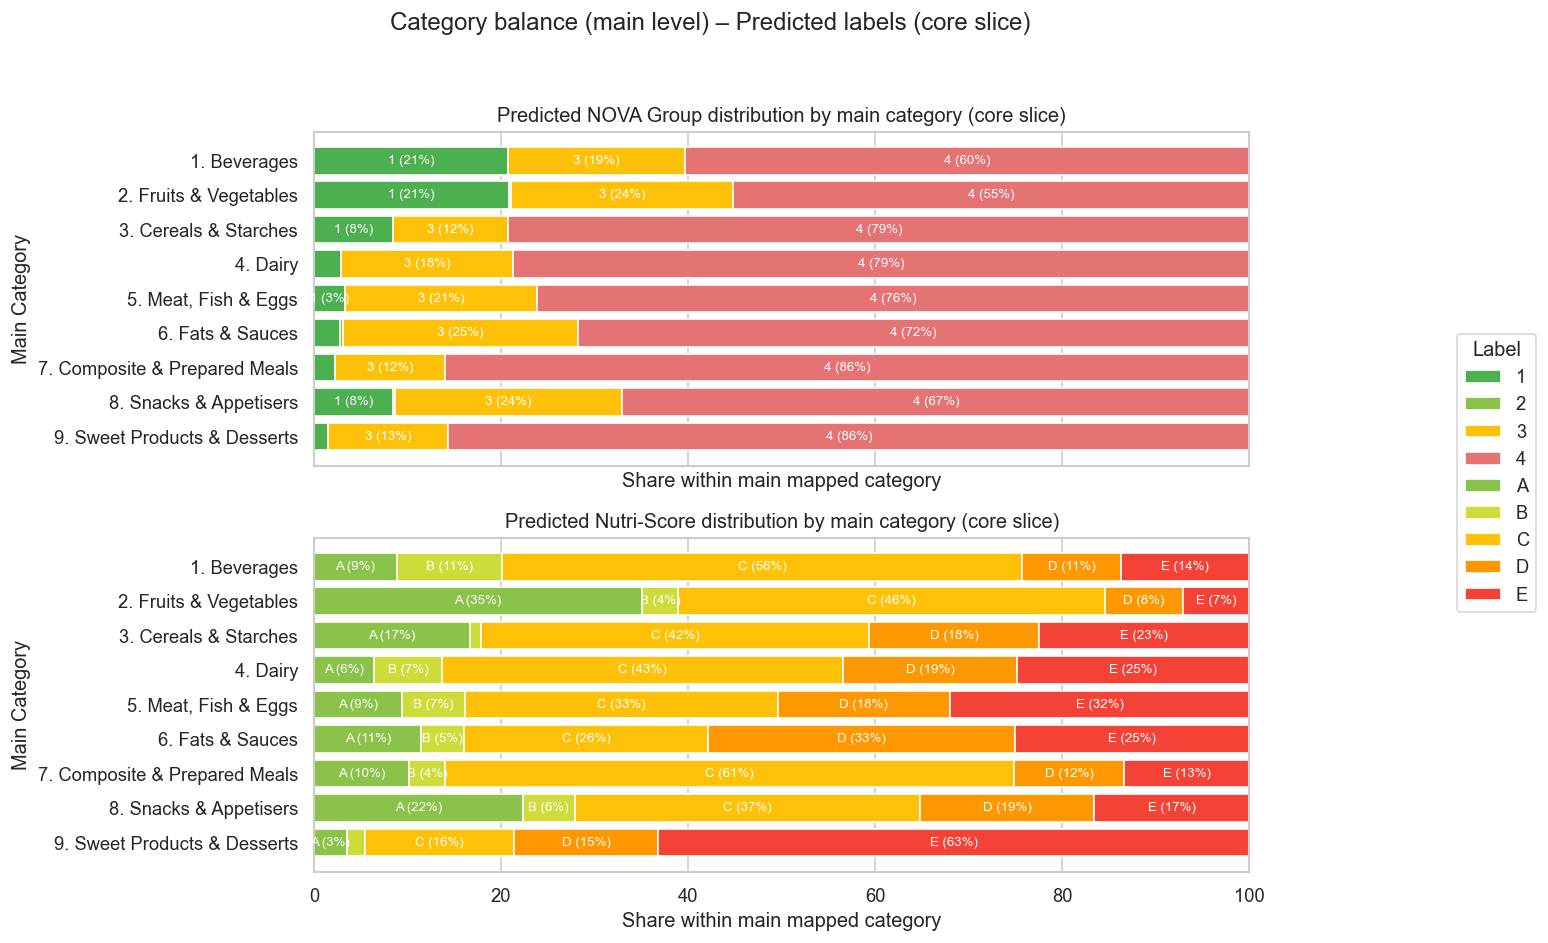

Saved: ../results\interpretability_combined\core_predicted_category_balance_nutri_nova.png


In [7]:
# 3. Category balance – predicted NOVA + Nutri

df_cat = df_core.dropna(subset=["main_mapped_category"]).copy()
cat_order = sorted(df_cat["main_mapped_category"].unique())
df_cat["main_mapped_category"] = pd.Categorical(
    df_cat["main_mapped_category"],
    categories=cat_order,
    ordered=True,
)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_stacked_share(
    df_cat,
    group_col="main_mapped_category",
    label_col="nova_pred",
    label_order=nova_order,
    label_colors=nova_colors,
    ax=axes[0],
    title="Predicted NOVA Group distribution by main category (core slice)",
)

plot_stacked_share(
    df_cat,
    group_col="main_mapped_category",
    label_col="nutri_pred",
    label_order=nutri_order,
    label_colors=nutri_colors,
    ax=axes[1],
    title="Predicted Nutri-Score distribution by main category (core slice)",
)

axes[0].set_ylabel("Main Category")
axes[1].set_ylabel("Main Category")
axes[1].set_xlabel("Share within main mapped category")

axes[0].invert_yaxis()
axes[1].invert_yaxis()

# combined legend (NOVA + Nutri)
h0, l0 = axes[0].get_legend_handles_labels()
h1, l1 = axes[1].get_legend_handles_labels()
seen = {}
for h, lab in zip(h0 + h1, l0 + l1):
    if lab not in seen:
        seen[lab] = h
handles = list(seen.values())
labels  = list(seen.keys())

leg = fig.legend(
    handles,
    labels,
    title="Label",
    loc="center right",
    bbox_to_anchor=(1.08, 0.5),
)

plt.suptitle("Category balance (main level) – Predicted labels (core slice)", y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

out_path = os.path.join(plot_dir, "core_predicted_category_balance_nutri_nova.png")

plt.savefig(
    out_path,
    dpi=300,
    bbox_inches="tight",
    bbox_extra_artists=(leg,),
)

plt.show()
print("Saved:", out_path)

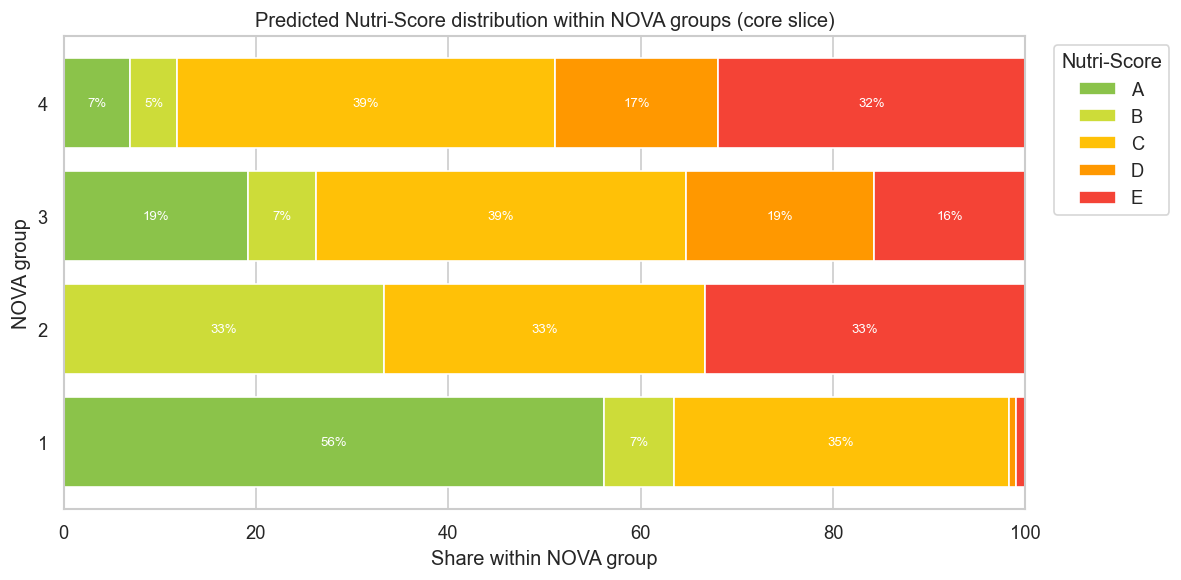

Saved: ../results\interpretability_combined\core_predicted_nutri_within_nova.png


In [11]:
# 4. Nutri-Score distribution within NOVA groups (predicted)

df_ng = df_core.dropna(subset=["nova_pred", "nutri_pred"]).copy()
df_ng["nova_pred"] = df_ng["nova_pred"].astype(int)

# Ensure ordering of NOVA groups
df_ng["nova_pred"] = pd.Categorical(df_ng["nova_pred"], categories=[1, 2, 3, 4], ordered=True)

fig, ax = plt.subplots(figsize=(10, 5))

plot_stacked_share(
    df_ng,
    group_col="nova_pred",
    label_col="nutri_pred",
    label_order=nutri_order,
    label_colors=nutri_colors,
    ax=ax,
    title="Predicted Nutri-Score distribution within NOVA groups (core slice)",
    text_fmt="{pct}%", 
)

ax.set_ylabel("NOVA group")
ax.set_xlabel("Share within NOVA group")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Nutri-Score", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()

out_path2 = os.path.join(plot_dir, "core_predicted_nutri_within_nova.png")
plt.savefig(out_path2, dpi=300)
plt.show()
print("Saved:", out_path2)